In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.special import expit as logistic

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [11]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [12]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [13]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.Data("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.27,0.11,0.05,0.47,0.0,0.0,3789.83,2816.76,1.0
betas[1],1.19,0.14,0.95,1.46,0.0,0.0,3949.69,2882.65,1.0


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

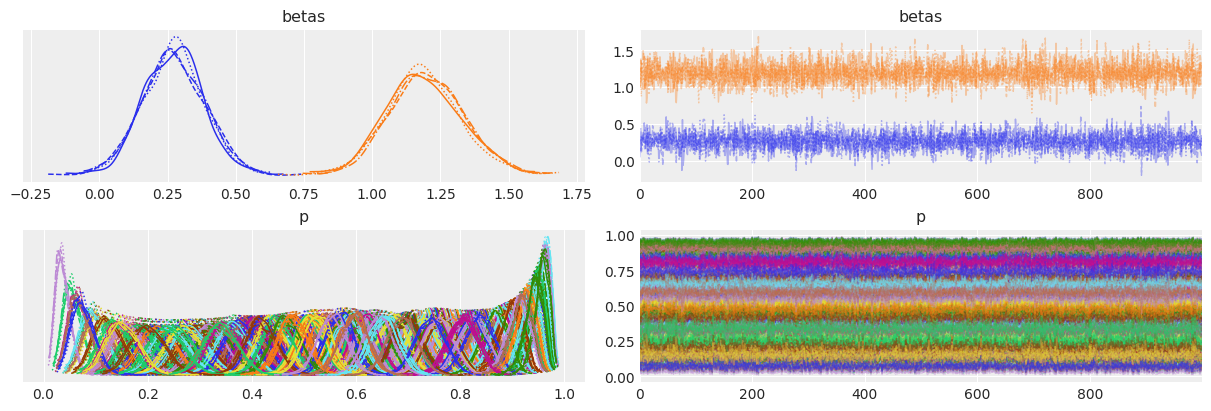

In [14]:
az.plot_trace(idata_2)

In [15]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: []


Output()

In [16]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

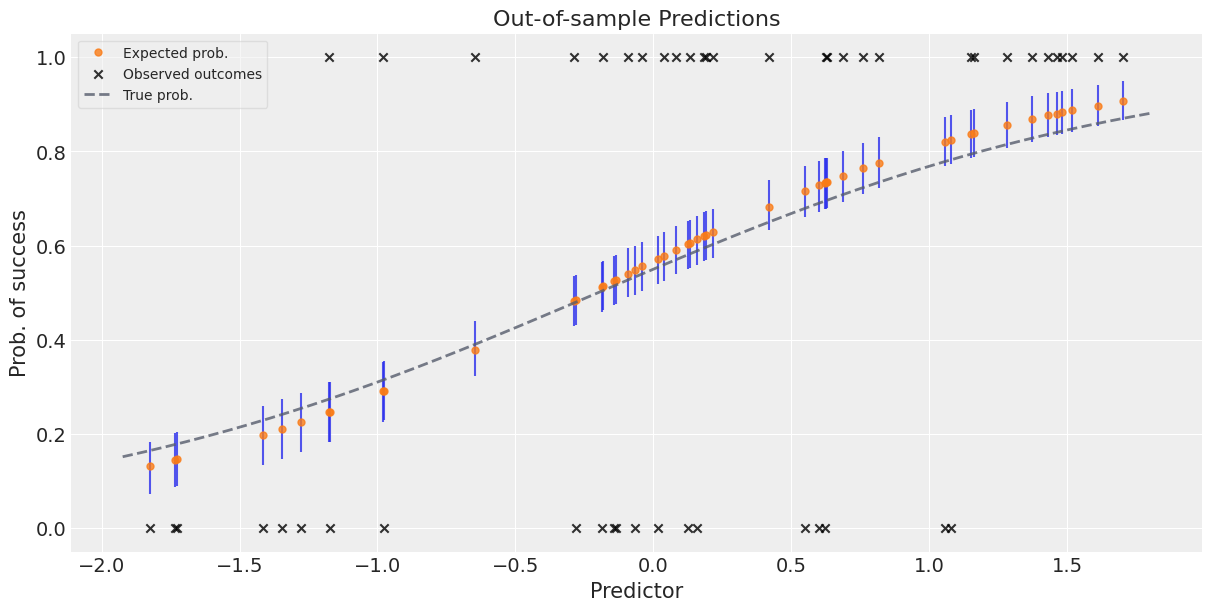

In [17]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

In [18]:
preds_out_of_sample

<xarray.DataArray 'pred' (obs_id: 50)> Size: 400B
array([-1.8235067 , -1.73394626, -1.72587105, -1.41433505, -1.34751955,
       -1.27562804, -1.17437386, -1.17106374, -0.98066116, -0.9762755 ,
       -0.64619765, -0.28881473, -0.2807912 , -0.18802951, -0.18276314,
       -0.14367288, -0.13696541, -0.09322669, -0.068149  , -0.03969434,
        0.01723318,  0.03831253,  0.08144262,  0.12465467,  0.13390892,
        0.15909993,  0.18443769,  0.19143789,  0.21410385,  0.41717265,
        0.55080034,  0.60080874,  0.62190918,  0.62712116,  0.63005716,
        0.68712658,  0.76098326,  0.81698418,  1.05745767,  1.07936013,
        1.15097366,  1.16302293,  1.28127226,  1.37241329,  1.42903446,
        1.46230669,  1.48168015,  1.51712844,  1.6107235 ,  1.70066301])
Coordinates:
  * obs_id   (obs_id) int64 400B 44 34 12 31 6 27 16 38 ... 24 49 25 41 11 23 32

In [19]:
model_preds

<xarray.Dataset> Size: 2MB
Dimensions:  (chain: 4, draw: 1000, obs_id: 50)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_id   (obs_id) int64 400B 44 34 12 31 6 27 16 38 ... 24 49 25 41 11 23 32
Data variables:
    p        (chain, draw, obs_id) float64 2MB 0.1572 0.1696 ... 0.9076 0.9166
Attributes:
    created_at:                 2025-08-22T11:00:51.351313+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1